In [8]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from typing import Union
from PIL import Image
from torch import Tensor

In [9]:
# SOURCE: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
root_dir_test = ''
data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)
testloader = DataLoader(test_image_dataset, batch_size=16, shuffle=True)

In [10]:
device = torch.device("cpu")
model = models.resnet50()
num_inftr = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_inftr, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load('model.pth',map_location=torch.device('cpu')))
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# SOURCE: https://github.com/kvarun07/covid-19-detection/blob/main/Covid-19-detection.ipynb
class_names = testloader.dataset.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            image = image.numpy().transpose((1, 2, 0))
            
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)
            
            colour = 'green' if preds[i] == labels[i] else 'red'
            plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
    plt.tight_layout()        
    plt.show()

In [12]:
# SOURCE: https://github.com/kvarun07/covid-19-detection/blob/main/Covid-19-detection.ipynb
def show_preds():
    model.eval()    # set to evaluation mode
    images, labels = next(iter(testloader))
    outputs = model(images)
    _ , preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

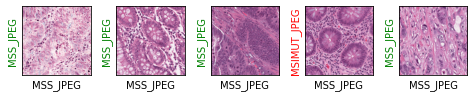

In [13]:
show_preds()

In [14]:
# SOURCE: https://www.kaggle.com/yangdliu/notebook285235a998
def to_numpy(tensor: Union[Tensor, Image.Image, np.array]) -> np.ndarray:
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            prediction = outputs.argmax(dim=1, keepdim=True)
            actuals.extend(to_numpy(labels.view_as(prediction)))
            predictions.extend(to_numpy(prediction))
            
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('Confusion matrix for resnet50: ')
print(confusion_matrix(actuals, predictions))
print('AUC score for model resnet50: '+str(roc_auc_score(actuals,predictions)))

Confusion matrix for resnet50: 
[[299 135]
 [ 88 564]]
AUC score for model resnet50: 0.7769853835062621
